IN PROGRESS
========
* RETRAINING USING A BALANCED SET.  For each annotator, compute precent correct for each preposition.  Compare to model performance.
 * If ranking of preposition difficulty for humans differs from that of the model, include correlation of F1 and train N in paper as a possible explanation for the difference.
 * If ranking of preposition difficulty for humans differs from that of the model, downsample the overrepresented classes in the training set so it's balanced, and retrain.  I'm not sure this would change the results, but that's OK.  The submission deadline is in January, it only takes a week to train the model, and the analysis is repeatable, so completing this task essentially only requires (1) the initial downsampling and (2) the opportunity cost of *not* being able to train some other model at the same time.
 * Create a task-specific notebook just for running the sensitivity analysis.  This must run on a machine with a GPU.
* Re-run the feature evaluation models using balanced data.
 * Use a much lower capacity model and 1m sentences for training.
 * Do cross-validation over filter_width [2, 3, 4, 5], n_filters [10, 100, 1000], and feature sets [X], [Xwindow?] (for ? in 5,7,9), [Xwindow?NULL] (for ? in 5,7,9), [Xwindow? X] (for ? in 5,7,9), and [Xwindow?NULL X] (for ? in 5,7,9).

TODO
-------------
* Re-start the LSTM model with balanced data (later).
* Train a convolutional model using just the window (without replacing the preposition with the nonce).  Save the weights of the model every epoch.  Plot, over epochs, 
 * The number of principal components necessary to explain 95% of the variance (it should increase over time).
 * Box plots of all-pairs cosine similarity (they should decrease over time).
* Paper:
 * Add table of examples showing where humans disagree with the corpus (but the model agrees with the corpus), where the model disagrees with the corpus (but the human agrees with the corpus), and where the model and the human agree with one another (and they both disagree with the corpus).
 * Send first draft to Peter, Mark, Kyle, and Lakshmi.
 * Send first revision to Jim and Martha.
 * Send third revision to Jordan.
* Human annotations
 * Report inter-rater reliability as a matrix of Cohen's Kappa.
 * Show examples where humans disagree with corpus.

DONE
-----------
* Add verbose=False option to modeling.utils.load_model.
* Make script to read HDF5 file of data, get predictions and probabilities for the data from some model, add the predictions and probabilities to the in-memory HDF5 file, and write the HDF5 file to disc somewhere new.
* Write function to merge human judgements into a single data frame:
 * Make a separate data frame of sent_id, sentence.
 * Make the corpus an annotator of its own.
 * Make the model an annotator of its own.
 * One row per judgment (sent_id, annotator_id, ...).
 * Improving detection and correction (Will not do.  Precision-recall curves are sufficient).
   * Write functions to filter out sentences based on different criteria:
   * Sentence length
   * Number of unknown words
   * Whether the probability of the most probable class exceeds some threshold
* Week of November 16:
 * Friday
   * Change annotator confidence histograms so bars are the same height across the x axis.
* Week of 23:
  * Monday
   * Modify this notebook to load the HDF5 files containing probabilities/predictions.  I should be able to run the analysis in this notebook on a machine that doesn't have a GPU (e.g. my laptop).
   * Change `load_predict_save` to put predictions and probabilities in separate file named DATA_FILE-MODEL_UUID.h5 and the model configuration in a file named DATA_FILE-MODEL_UUID.json.
   * Change the train, validation, and test sets to be balanced.  Start retraining a convnet using the balanced data.
   * Add option to train_keras.py to ignore the weights in the target-data.json file so as to avoid bias when training with the balanced version of the data.
  * Tuesday
   * Write function and tests to add a window of k words (with and without nonce) to an .h5 file.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Use Times New Roman for NAACL. 
font = {'family' : 'serif',
        'serif': 'Times New Roman',
        'size'   : 12,
       }
plt.rc('font', **font)

text = {
        'latex.unicode': True,
        'latex.preamble': r"\usepackage{times}"
        }
plt.rc('text', **text)

In [2]:
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [3]:
import itertools

def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(
            itertools.combinations(s, r) for r in range(len(s)+1))

linestyle = itertools.cycle(['-', '--', '-.', ':'])

In [4]:
import shutil
import os
import json
import h5py

import pandas as pd

from sklearn.metrics import (confusion_matrix,
        fbeta_score, cohen_kappa_score,
        precision_recall_fscore_support, precision_recall_curve)
from sklearn.dummy import DummyClassifier

import modeling.utils

In [5]:
# For scikit learn metrics.
weighting = 'macro'

In [6]:
# model_dir = 'models/keras/preposition/convnet/4e0ae5dc683611e5950afcaa149e39ea'
# model_dir = 'models/keras/preposition/convnet/7a87f8e870f111e5950afcaa149e39ea'
# model_dir = 'models/keras/preposition/convnet/6cd818a886af11e59052fcaa149e39ea/'

# Accidentally terminated, but it was progressing nicely.
#model_dir = 'models/keras/preposition/convnet/7040fefc88c011e5b2b374d435ed6f3a/'

# Best so far, but imbalanced.
# model_dir = 'models/keras/preposition/convnet/20a7a6b088ee11e5b2b374d435ed6f3a/'

# Balanced.
# model_dir = 'models/keras/preposition/convnet/balanced/'

# Load the test set for evaluation.
# data_file = 'data/preposition/prepositions-all-new-test.h5'

In [7]:
# To generate the data file used by this notebook, run the following on a machine with a GPU.
# Set the model directory.
#model_dir = 'models/keras/prepositions/convnet/20a7a6b088ee11e5b2b374d435ed6f3a/'
# Set the data file.
# data_file = 'data/preposition/prepositions-all-new-test.h5'
# Load the model, get predictions, and save output.
#modeling.utils.load_predict_save(model_dir, data_file)
# model, model_cfg = modeling.utils.load_model(model_dir, load_weights=True)

In [8]:
model_id = '20a7a6b088ee11e5b2b374d435ed6f3a'
basename = 'data/preposition/wikipedia/prepositions-all-new'
qualifier = '-test'
target_data_file = basename + '-target-data.json'

In [788]:
book = ['emma', 'frankenstein', 'moby-dick',
        'pride-and-prejudice', 'the-adventures-of-tom-sawyer',
        'the-narrative-of-the-life-of-frederick-douglass',
        'ulysses', 'war-and-peace'][4]
model_id = 'Xwindow9NULL-X-01-hidden'
basename = 'data/preposition/gutenberg/' + book + '/'
qualifier = 'sentences'

In [789]:
# Load model predictions and softmax probabilities.
pred_file = basename + qualifier + '-' + model_id + '-pred.h5'
f = h5py.File(pred_file, 'r')
preds = f['pred'].value
probs = f['prob'].value
f.close()

In [790]:
# Load model configuration (i.e. hyperparameters and other settings).
model_json_file = basename + qualifier + '-' + model_id + '-cfg.json'
model_json = json.load(open(model_json_file))
model_cfg = modeling.utils.ModelConfig(**model_json)

In [791]:
# Load target data or metadata (e.g. mapping between numeric target variable and preposition).
target_data = json.load(open(target_data_file))

In [792]:
# Load targets (multiclass, binary), examples (e.g. windows around a preposition, the entire sentence),
# and other data about the inputs (e.g. the length of each sentence).
data_file = basename + qualifier + '.h5'
model_data = modeling.utils.load_all_model_data(data_file, model_cfg)

[(3836, 9), (3836, 52)]


In [793]:
evens = np.arange(0, len(preds), 2)
odds = evens + 1

In [794]:
dummy_prior = DummyClassifier(strategy='prior', random_state=17)
dummy_prior.fit(model_data.data, model_data.target)
preds_prior = dummy_prior.predict(model_data.data)
probs_prior = dummy_prior.predict_proba(model_data.data)

dummy_uniform = DummyClassifier(strategy='uniform', random_state=17)
dummy_uniform.fit(model_data.data, model_data.target)
preds_uniform = dummy_uniform.predict(model_data.data)
probs_uniform = dummy_uniform.predict_proba(model_data.data)

Error detection
========

The authors of the Chungdam paper report precision and recall for error detection and correction.  On detection, they report precision of 0.933 with **0.148** recall.  In this section we show that using a simple temporal convolutional network results in a precision of 0.94 at **0.91** recall.  The comparison is not quite apt, as errors are distributed differently in our data.  Error detection is a binary classification task and about half of the sentences in our corpus contain an error.  In the Chungdam corpus, errors are distributed ... how?  Similarly, the frequency of kinds of error is distributed differently in our corpus; the numbers of error are proportional to their occurrence in the original corpus.

In [795]:
error_detection_targets = np.ones_like(model_data.current_word_code)
error_detection_targets[evens] = 0

dummy_prior_error_detection_preds = (preds_prior != model_data.current_word_code).astype(int)
dummy_uniform_error_detection_preds = (preds_uniform != model_data.current_word_code).astype(int)
error_detection_preds = (preds != model_data.current_word_code).astype(int)

print('\nConfusion matrix for error detection (prior baseline)\n')
print(confusion_matrix(error_detection_targets, dummy_prior_error_detection_preds))

print('\nConfusion matrix for error detection (uniform baseline)\n')
print(confusion_matrix(error_detection_targets, dummy_uniform_error_detection_preds))

print('\nConfusion matrix for error detection\n')
print(confusion_matrix(error_detection_targets, error_detection_preds))

print('\nPerformance summary of error detection (prior baseline)\n')
p, r, f, s = precision_recall_fscore_support(
        error_detection_targets, dummy_prior_error_detection_preds, average='binary')
fbeta_05 = fbeta_score(error_detection_targets, dummy_prior_error_detection_preds, beta=0.5)
print(p, r, f, fbeta_05, s)

print('\nPerformance summary of error detection (uniform baseline)\n')
p, r, f, s = precision_recall_fscore_support(
        error_detection_targets, dummy_uniform_error_detection_preds, average='binary')
fbeta_05 = fbeta_score(error_detection_targets, dummy_uniform_error_detection_preds, beta=0.5)
print(p, r, f, fbeta_05, s)

print('\nPerformance summary of error detection\n')
p, r, f, s = precision_recall_fscore_support(
        error_detection_targets, error_detection_preds, average='binary')
fbeta_05 = fbeta_score(error_detection_targets, error_detection_preds, beta=0.5)
print(p, r, f, fbeta_05, s)


Confusion matrix for error detection (prior baseline)

[[ 331 1587]
 [ 194 1724]]

Confusion matrix for error detection (uniform baseline)

[[ 195 1723]
 [ 232 1686]]

Confusion matrix for error detection

[[1638  280]
 [ 354 1564]]

Performance summary of error detection (prior baseline)

(0.52068861371186947, 0.89885297184567259, 0.65939950277299664, 0.568526579606912, None)

Performance summary of error detection (uniform baseline)

(0.49457318861836314, 0.87904066736183528, 0.63300168950628866, 0.54198276970554204, None)

Performance summary of error detection

(0.84815618221258138, 0.81543274244004171, 0.83147262094630514, 0.84140305573488283, None)


Error correction
========

On error correction, the authors of the Chungdam corpus paper report precision 0.817 at recall of 0.132.  Our model -- not quite the best performing one we have -- achieves 0.803 precision at a recall of 0.803.

In [796]:
p, r, f, _ = precision_recall_fscore_support(
        model_data.target, 
        model_data.current_word_code,
        average=weighting)
fbeta_05 = fbeta_score(
        model_data.target,
        model_data.current_word_code,
        beta=0.5, average=weighting)

print('{model_type:20s} Precision {precision:.03f} Recall {recall:.03f} F1 {f1:.03f} Fbeta-0.5 {fbeta:.03f} N {N:d}'.format(
        model_type='No-change baseline',
        precision=p, recall=r, f1=f, fbeta=fbeta_05, N=len(model_data.target)))

p, r, f, _ = precision_recall_fscore_support(
        model_data.target, 
        preds_prior,
        average=weighting)
fbeta_05 = fbeta_score(
        model_data.target,
        preds_prior,
        beta=0.5, average=weighting)

print('{model_type:20s} Precision {precision:.03f} Recall {recall:.03f} F1 {f1:.03f} Fbeta-0.5 {fbeta:.03f} N {N:d}'.format(
        model_type='Prior baseline',
        precision=p, recall=r, f1=f, fbeta=fbeta_05, N=len(model_data.target)))

p, r, f, _ = precision_recall_fscore_support(
        model_data.target, 
        preds_uniform,
        average=weighting)
fbeta_05 = fbeta_score(
        model_data.target,
        preds_uniform,
        beta=0.5, average=weighting)

print('{model_type:20s} Precision {precision:.03f} Recall {recall:.03f} F1 {f1:.03f} Fbeta-0.5 {fbeta:.03f} N {N:d}'.format(
        model_type='Uniform baseline',
        precision=p, recall=r, f1=f, fbeta=fbeta_05, N=len(model_data.target)))

p, r, f, _ = precision_recall_fscore_support(
        model_data.target, 
        preds,
        average=weighting)
fbeta_05 = fbeta_score(
        model_data.target,
        preds,
        beta=0.5, average=weighting)

print('{model_type:20s} Precision {precision:.03f} Recall {recall:.03f} F1 {f1:.03f} Fbeta-0.5 {fbeta:.03f} N {N:d}'.format(
        model_type='Real model',
        precision=p, recall=r, f1=f, fbeta=fbeta_05, N=len(model_data.target)))

No-change baseline   Precision 0.482 Recall 0.500 F1 0.484 Fbeta-0.5 0.481 N 3836
Prior baseline       Precision 0.019 Recall 0.111 F1 0.033 Fbeta-0.5 0.023 N 3836
Uniform baseline     Precision 0.101 Recall 0.101 F1 0.098 Fbeta-0.5 0.099 N 3836
Real model           Precision 0.690 Recall 0.688 F1 0.685 Fbeta-0.5 0.687 N 3836


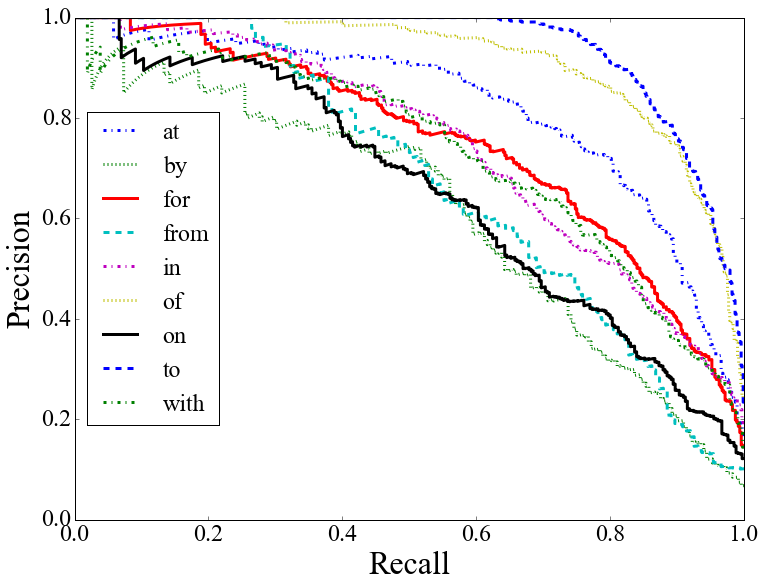

In [797]:
# Limit the scope of the variables in this cell by encapsulating them
# in a function.  Otherwise, their scope is that of the entire notebook,
# which makes variable names do more work than they ought to.  (This is
# so because in Python 2.7, variables declared inside loops are automatically
# promoted to their outer enclosing environment; I think this is no longer
# the case in Python 3 [so upgrade]).
def per_class_precision_recall_curves():
    #plt.figure(figsize=(9,6))
    
    all_prec = []
    all_rec = []
    all_prep = []
    
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111)
    
    label_props = {'size': 32 }
    legend_props = ticks_props = { 'size': 24 }
    
    plt.setp(ax.get_xticklabels(), fontsize=legend_props['size'])
    plt.setp(ax.get_yticklabels(), fontsize=legend_props['size'])
    
    for code, preposition in enumerate(target_data['original_word_code']['names']):
        # Convert the targets to 0-1 for this preposition.
        targets_binary = model_data.target.copy()
        mask = targets_binary == code
        targets_binary[mask] = 1
        targets_binary[~mask] = 0

        # Convert the n-way softmax to a binary classification probability by taking
        # the column from the softmax that corresponds to this preposition.
        probs_binary = probs[:, code]

        prec, rec, _ = precision_recall_curve(
            targets_binary, probs_binary)
        ax.plot(rec, prec, label=preposition, ls=next(linestyle), linewidth=3)
        
        all_prec.extend(prec)
        all_rec.extend(rec)
        all_prep.extend([preposition] * len(prec))

    ax.set_xlabel('Recall', **label_props)
    ax.set_ylabel('Precision', **label_props)
    ax.legend(loc='center left', prop=legend_props)
    plt.savefig('figures/precision-recall.pdf')
    
    return pd.DataFrame({
            'Precision': all_prec,
            'Recall': all_rec,
            'Preposition': all_prep
            })
    
precision_recall_df = per_class_precision_recall_curves()

Improving detection and correction performance
==============
There are three ways improve detection and correction.  Only allow the model to make a correction if:
1. the sentence is a good length (neither too long nor too short -- 8-18 words?)
1. the sentence contains no or very few unknown words.
1. the probability of the most probable class is high.

In [798]:
def compute_n_unknown_words():
    n_unknown_words = np.zeros_like(model_data.len)
    for i in np.arange(0, len(model_data.len)):
        n_unknown_words[i] = len(np.where(model_data.data[i, 0:model_data.len[i]] == 0)[0])
    return n_unknown_words

def sentence_length_constraint(min_len=8, max_len=20):
    return (model_data.len > 8) & (model_data.len < 20)

def number_of_unknown_words_constraint(n_unknown=0):
    n_unknown_words = compute_n_unknown_words()
    return n_unknown_words <= n_unknown
    
def performance_with_constraints():
    right_length = sentence_length_constraint()
    no_unknown_words = number_of_unknown_words_constraint()
    both_constraints = right_length & no_unknown_words
    
    p, r, f, s = precision_recall_fscore_support(
            model_data.target[right_length], 
            preds[right_length],
            average=weighting)
    fbeta_05 = fbeta_score(
            model_data.target[right_length],
            preds[right_length],
            beta=0.5, average=weighting)
    print('Error correction performance with sentence length constraint')
    print(p, r, f, fbeta_05, sum(right_length))
    
    p, r, f, s = precision_recall_fscore_support(
            model_data.target[no_unknown_words], 
            preds[no_unknown_words],
            average=weighting)
    fbeta_05 = fbeta_score(
            model_data.target[no_unknown_words],
            preds[no_unknown_words],
            beta=0.5, average=weighting)
    print('Error correction performance with no unknown words constraint')
    print(p, r, f, fbeta_05, sum(no_unknown_words))
    
    p, r, f, s = precision_recall_fscore_support(
            model_data.target[both_constraints], 
            preds[both_constraints],
            average=weighting)
    fbeta_05 = fbeta_score(
            model_data.target[both_constraints],
            preds[both_constraints],
            beta=0.5, average=weighting)
    print('Error correction performance with length and unknown words constraints')
    print(p, r, f, fbeta_05, sum(both_constraints))
    
    
performance_with_constraints()

Error correction performance with sentence length constraint
(0.68305259573279198, 0.68390812463688944, 0.67859648008851758, 0.68008293420736665, 1712)
Error correction performance with no unknown words constraint
(0.68905040392170958, 0.69954524265621409, 0.6899812449827758, 0.68841346791357061, 1464)
Error correction performance with length and unknown words constraints
(0.67588808588361893, 0.68891782263429768, 0.67801510894004968, 0.675672409121156, 634)


Effect of length on model performance
=======

For this particular convolutional network, performance degrades with length.  I should run these reports with and without sentences that contain unknown words, in order to control for that variable.

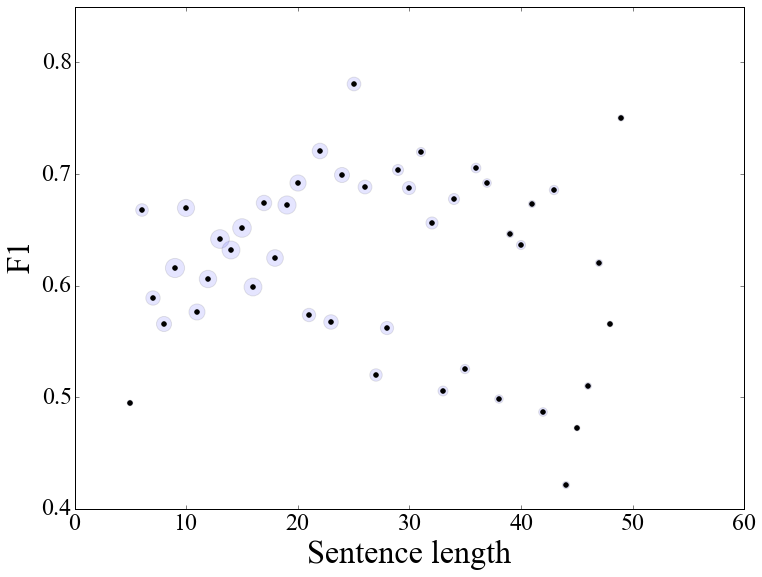

In [799]:
def plot_performance_by_length():
    f1_by_length = []
    
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111)
    
    label_props = {'size': 32 }
    legend_props = { 'size': 24 }
    
    plt.setp(ax.get_xticklabels(), fontsize=legend_props['size'])
    plt.setp(ax.get_yticklabels(), fontsize=legend_props['size'])

    for start in np.arange(5, 50):
        end = start + 1
        idx = np.where((model_data.len >= start) & (model_data.len < end))[0]
        p, r, f, s = precision_recall_fscore_support(
                model_data.target[idx],
                preds[idx],
                average=weighting)
        #f1_by_length.append(f)
        ax.scatter(start, f, s=len(idx)*2, alpha=.1)
        ax.scatter(start, f, c='black')
        #print("{start:02d}-{end:02d} {precision:.2f} {recall:.2f} {f:.2f} {support:6d}".format(
        #        start=start, end=end, precision=p, recall=r, f=f, support=len(idx)))
    
    ax.set_xlabel('Sentence length', **label_props)
    ax.set_ylabel('F1', **label_props)

    plt.savefig('figures/f1-by-length.pdf')
    
plot_performance_by_length()

Error detection performance conditioned on original (correct) preposition (i.e. the target variable)
========
"For" is the preposition with the lowest precision, recall, F-1, and F-0.5.

In [800]:
for code, word in enumerate(target_data['original_word_code']['names']):
    targets_with_code_idx = np.where(model_data.target == code)[0]
    error_detection_targets_word = error_detection_targets[targets_with_code_idx]
    error_detection_preds_word = (
        preds[targets_with_code_idx] != model_data.current_word_code[targets_with_code_idx]
    ).astype(int)

    p, r, f, s = precision_recall_fscore_support(
            error_detection_targets_word,
            error_detection_preds_word,
            average='binary')
    
    fbeta_05 = fbeta_score(
            error_detection_targets_word,
            error_detection_preds_word,
            average='binary',
            beta=0.5)
    
    df_row = pd.DataFrame({
                'code': [code],
                'word': [word],
                'precision': [p],
                'recall': [r],
                'f1': [f],
                'fbeta_05': [fbeta_05],
                'n': [len(targets_with_code_idx)]
            })
    
    print("{code} {word:5s} {precision:.2f} {recall:.2f} {f1:.2f} {fbeta:.2f} {n:6d}".format(
            code=code, word=word, precision=p, recall=r, f1=f, fbeta=fbeta_05, n=len(targets_with_code_idx)))

0 at    0.84 0.83 0.83 0.84    378
1 by    0.72 0.76 0.74 0.73    232
2 for   0.86 0.82 0.84 0.85    456
3 from  0.79 0.79 0.79 0.79    174
4 in    0.76 0.76 0.76 0.76    584
5 of    0.91 0.86 0.88 0.90    602
6 on    0.80 0.81 0.80 0.80    330
7 to    0.96 0.88 0.91 0.94    662
8 with  0.87 0.77 0.81 0.85    418


Error detection performance conditioned on actual (possibly incorrect) preposition
=======
We would like to measure the difficulty of detecting an error given the actual preposition.  The prepositions with the lowest precision, recall, and F1, and F-0.5 are "for", "in", "in", and "for", respectively.

In [801]:
for code, word in enumerate(target_data['current_word_code']['names']):
    targets_with_code_idx = np.where(model_data.current_word_code == code)[0]
    error_detection_targets_word = error_detection_targets[targets_with_code_idx]
    error_detection_preds_word = (preds[targets_with_code_idx] != model_data.current_word_code[targets_with_code_idx]).astype(int)

    p, r, f, s = precision_recall_fscore_support(
            error_detection_targets_word,
            error_detection_preds_word,
            average='binary')
    fbeta_05 = fbeta_score(
            error_detection_targets_word,
            error_detection_preds_word,
            beta=0.5,
            average='binary')
    print("{code} {word:5s} {precision:.2f} {recall:.2f} {f1:.2f} {fbeta:.2f} {n:6d}".format(
            code=code, word=word, precision=p, recall=r, f1=f, fbeta=fbeta_05, n=len(targets_with_code_idx)))

0 at    0.87 0.91 0.89 0.88    410
1 by    0.86 0.89 0.87 0.86    344
2 for   0.83 0.71 0.76 0.80    441
3 from  0.91 0.82 0.86 0.89    318
4 in    0.70 0.83 0.76 0.73    496
5 of    0.87 0.89 0.88 0.88    503
6 on    0.83 0.74 0.78 0.81    382
7 to    0.92 0.80 0.86 0.89    525
8 with  0.87 0.74 0.80 0.84    417


Error correction performance conditioned on original preposition
--------

In [802]:
word = target_data['current_word_code']['names']
codes = np.arange(len(word))
p, r, f, s = precision_recall_fscore_support(
        model_data.target,
        preds,
        average=None)
fbeta_05 = fbeta_score(
        model_data.target,
        preds,
        beta=0.5,
        average=None)
df_correction = pd.DataFrame({
        'word': word,
        'precision': p,
        'recall': r,
        'f1': f,
        'fbeta_05': fbeta_05,
        'n': s
        })
df_correction = df_correction[['word', 'precision', 'recall', 'f1', 'n']]
print(df_correction.to_latex(index=False, float_format=lambda f: '%.02f' % f))

\begin{tabular}{lrrrr}
\toprule
 word &  precision &  recall &   f1 &    n \\
\midrule
   at &       0.77 &    0.71 & 0.74 &  378 \\
   by &       0.70 &    0.54 & 0.61 &  232 \\
  for &       0.66 &    0.70 & 0.68 &  456 \\
 from &       0.54 &    0.64 & 0.58 &  174 \\
   in &       0.77 &    0.57 & 0.66 &  584 \\
   of &       0.83 &    0.81 & 0.82 &  602 \\
   on &       0.54 &    0.65 & 0.59 &  330 \\
   to &       0.81 &    0.87 & 0.84 &  662 \\
 with &       0.61 &    0.70 & 0.65 &  418 \\
\bottomrule
\end{tabular}



Error correction performance conditioned on actual (possibly incorrect) preposition and original (correct) preposition
========

In [803]:
def error_correction_performance_conditioned_on_actual_and_original():
    correction_conditioned_actual_orig = []

    n_error_correction = (error_detection_preds == 1).sum()

    for current_word_code, current_word in enumerate(target_data['current_word_code']['names']):
        # Error correction performance is only computed over the examples for which
        # the model's predicted preposition differs from the actual preposition.

        # First find the examples for which the model's predicted preposition differs from
        # the actual preposition.
        error_correction_mask = error_detection_preds == 1

        # Then find the examples that have the given original preposition.
        targets_with_code = model_data.current_word_code == current_word_code

        targets_with_code_idx = np.where(error_correction_mask & targets_with_code)[0]
        error_correction_targets_word = model_data.target[targets_with_code_idx]
        error_correction_preds_word = preds[targets_with_code_idx]

        error_correction_targets_word = error_correction_targets_word
        error_correction_preds_word = error_correction_preds_word

        p, r, f, s = precision_recall_fscore_support(
                error_correction_targets_word,
                error_correction_preds_word,
                average=None)

        for original_word_code, original_word in enumerate(target_data['original_word_code']['names']):
            f1_macro = f[original_word_code] * s[original_word_code] / n_error_correction
            correction_conditioned_actual_orig.append({
                    'current_word': current_word,
                    'original_word': original_word,
                    'precision': p[original_word_code],
                    'recall': r[original_word_code],
                    'f1': f[original_word_code],
                    'f1macro': f1_macro,
                    'n': s[original_word_code]
                })

    df = pd.DataFrame(correction_conditioned_actual_orig)
    df = df.sort(['f1'])
    df = df[['current_word', 'original_word', 'precision', 'recall', 'f1', 'f1macro', 'n']]
    pd.set_option('display.precision', 3)

    print('The 20 most difficult current-original word pairs\n')
    print(df[df.precision > 0].head(n=20))
    print('')

    print('The 20 easiest current-original word pairs\n')
    print(df[df.precision > 0].tail(n=20))
    print('')

    print(df[df.precision > 0].f1macro.sum())
    
#error_correction_performance_conditioned_on_actual_and_original()

In [804]:
df_sizes = pd.DataFrame({
        'preposition': target_data['original_word_code']['names'],
        'n': np.bincount(model_data.target)
        })
df_sizes[['preposition', 'n']]

,preposition,n
0,at,378
1,by,232
2,for,456
3,from,174
4,in,584
5,of,602
6,on,330
7,to,662
8,with,418


Correlation of number of examples and performance
===========
The distribution of errors in the validation set is proportional to that of the training set.  The figures and tables below explore the relationship between the number of training examples and the performance on each kind of example.

In [805]:
def plot_performance_by_number_of_examples():
    plt.figure(figsize=(15,8))
    cols = ['red', 'blue', 'green', 'magenta', 'yellow', 'pink', 'cyan', 'brown', 'gray', 'black']
    for i, original_word in enumerate(target_data['original_word_code']['names']):
        df_original_word = df[(df.f1 > 0) & (df.original_word == original_word)]
        plt.scatter(df_original_word.n, df_original_word.f1, c=cols[i], label=original_word, s=40)
    plt.legend(loc='lower right')
#plot_performance_by_number_of_examples()

In [806]:
def plot_performance_by_number_of_examples_without_in():
    df_without_in = df[df.original_word != 'in']
    print(np.corrcoef(df_without_in[df_without_in.f1 > 0].n, df_without_in[df_without_in.f1 > 0].f1))
    plt.figure(figsize=(12,9))
    cols = ['red', 'blue', 'green', 'magenta', 'yellow', 'pink', 'cyan', 'brown', 'gray', 'black']
    for i, original_word in enumerate(target_data['original_word_code']['names']):
        if original_word == 'in':
            continue
        df_original_word = df_without_in[(df_without_in.f1 > 0) & (df_without_in.original_word == original_word)]
        plt.scatter(df_original_word.n, df_original_word.f1, c=cols[i], label=original_word, s=40)
    plt.legend(loc='lower right')
#plot_performance_by_number_of_examples_without_in()

Sizes of things
========

In [807]:
train_size = 59972006
validation_size = 999532
test_size = 999552

In [808]:
def sizes():
    df_sizes = pd.DataFrame({
        'preposition': target_data['original_word_code']['names'],
        'n': np.bincount(model_data.target)
        })
    df = df_sizes[['preposition', 'n']]
    print(df)
    print(df.to_latex(index=False))
sizes()

  preposition    n
0          at  378
1          by  232
2         for  456
3        from  174
4          in  584
5          of  602
6          on  330
7          to  662
8        with  418
\begin{tabular}{lr}
\toprule
preposition &    n \\
\midrule
         at &  378 \\
         by &  232 \\
        for &  456 \\
       from &  174 \\
         in &  584 \\
         of &  602 \\
         on &  330 \\
         to &  662 \\
       with &  418 \\
\bottomrule
\end{tabular}



In [809]:
google_n_gram_pcts = np.array([.3015, .4219, .6588, .3345, 1.559, 2.939, .4719, 1.976, .516])
normalized_google_n_gram_pcts = google_n_gram_pcts / google_n_gram_pcts.sum()
print(normalized_google_n_gram_pcts)

[ 0.033  0.046  0.072  0.036  0.17   0.32   0.051  0.215  0.056]


In [810]:
#df_convnet = pd.read_csv('models/keras/preposition/convnet/20a7a6b088ee11e5b2b374d435ed6f3a/val_acc.csv')
#df_lstm = pd.read_csv('models/keras/preposition/lstm/b7fb442a677b11e59dd822000a4389ba/val_acc.csv')

In [811]:
# plt.figure(figsize=(15,12))
# plt.scatter(range(1, len(df_convnet)+1), df_convnet.ix[:, 0], alpha=0.75, label='ConvNet', c='red')
# plt.scatter(range(1, len(df_lstm)+1), df_lstm.ix[:, 0], alpha=0.75, label='LSTM', c='green')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.xlim(0, max(len(df_convnet), len(df_lstm))+1)
# plt.legend()

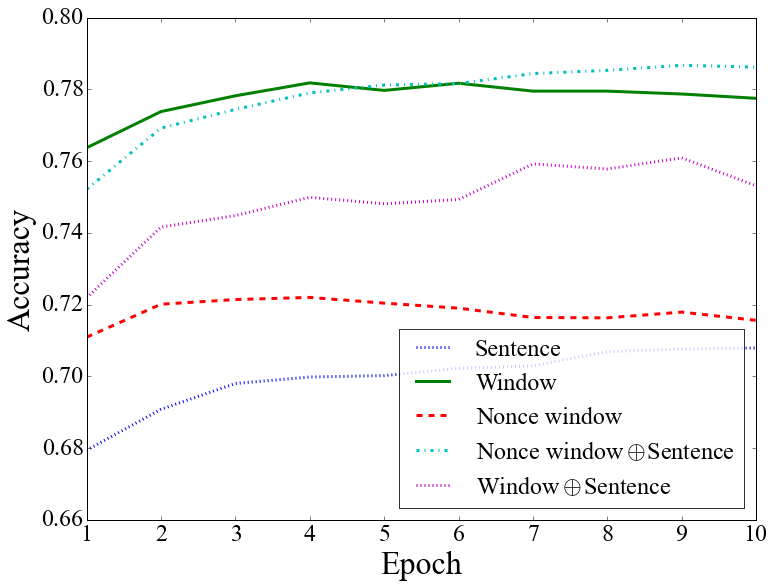

In [812]:
def plot_feature_comparison():
    feature_comparison_csv = os.environ['HOME'] + '/proj/dissertation/projects/cnn/data/preposition/figures/preposition-feature-comparison.csv'
    feature_comparison_df = pd.read_csv(feature_comparison_csv, sep='\t')
    
    plt.figure(figsize=(12,9))
    ax = plt.subplot(111)
    
    label_props = {'size': 32 }
    legend_props = { 'size': 24 }
    
    plt.setp(ax.get_xticklabels(), fontsize=legend_props['size'])
    plt.setp(ax.get_yticklabels(), fontsize=legend_props['size'])
    
    def rename_nonce(s):
        return s
        if s == 'Nonce window':
            return 'Nonce'
        return s
    
    for features in feature_comparison_df.Features.unique():
        if '+' in features:
            fields = features.split('+')
            fields[0] = rename_nonce(fields[0])
            label = fields[0] + r'$\oplus$' + fields[1]
        else:
            label = rename_nonce(features)
        df_features = feature_comparison_df[feature_comparison_df.Features == features]
        ax.plot(df_features.Epoch, df_features.ValAcc, label=label, ls=next(linestyle), linewidth=3)
    
    ax.set_xlabel('Epoch', **label_props)
    ax.set_ylabel('Accuracy', **label_props)
    leg = ax.legend(loc='lower right', prop=legend_props)
    leg.get_frame().set_alpha(0.8)
    plt.savefig('figures/preposition-feature-comparison-valid.pdf')
    
plot_feature_comparison()